# LDDMM: how to register a mesh to a template?

In [1]:
from pathlib import Path

import numpy as np
import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing import Map
from polpo.preprocessing.load.deformetrica import LoadMeshFlow
from polpo.preprocessing.load.pregnancy.pilot import (
    HippocampalSubfieldsSegmentationsLoader,
)
from polpo.preprocessing.mesh.conversion import PvFromData
from polpo.preprocessing.mesh.io import PvWriter
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.mesh.smoothing import PvSmoothTaubin
from polpo.preprocessing.mesh.transform import MeshCenterer
from polpo.preprocessing.mri import (
    MeshExtractorFromSegmentedImage,
    MeshExtractorFromSegmentedMesh,
)

No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
ONLY_VIS = False  # in case registration has already been run
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
SOURCE_INDEX = 3
TARGET_INDEX = 14

STRUCT_NAME = "PostHipp"

OUTPUTS_DIR = Path("results") / f"registration_{STRUCT_NAME.lower()}"
REGISTRATION_DIR = OUTPUTS_DIR / "registration"

OUTPUTS_DIR.mkdir(exist_ok=True)

## Load meshes

Following [How to get a mesh from an MRI image?](./mri2mesh.ipynb), we start by loading two selected meshes. See also [How to select a mesh subset?](./hipp_substructures.ipynb).


In [4]:
struct_from_image = True

path2img = HippocampalSubfieldsSegmentationsLoader(
    subset=[SOURCE_INDEX, TARGET_INDEX], as_image=True
)

if struct_from_image:
    img2mesh = MeshExtractorFromSegmentedImage(
        struct_id=STRUCT_NAME, encoding="ashs"
    ) + PvFromData(keep_colors=False)
else:
    img2mesh = (
        MeshExtractorFromSegmentedImage(struct_id=-1, encoding="ashs")
        + PvFromData()
        + MeshExtractorFromSegmentedMesh(struct_id=STRUCT_NAME, encoding="ashs")
    )

pipe = path2img + ppdict.DictMap(img2mesh) + ppdict.DictToValuesList()

In [5]:
meshes = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/derivatives/segmentations').


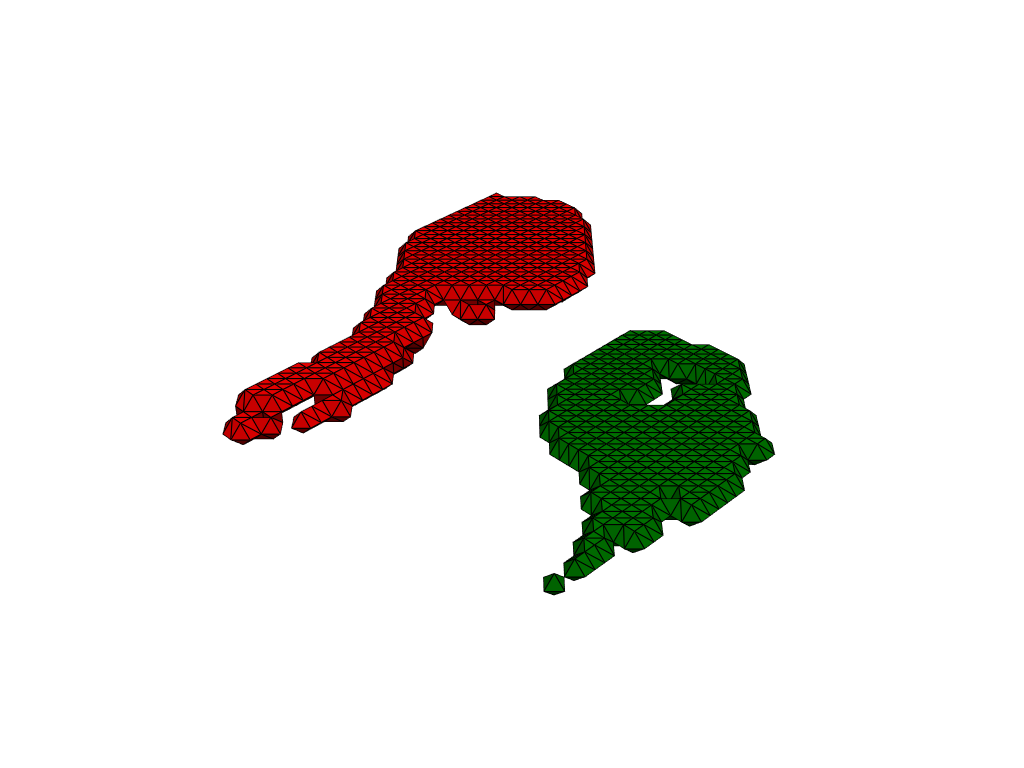

In [6]:
pl = pv.Plotter(border=False)

pl.add_mesh(meshes[0], show_edges=True, color="red")
pl.add_mesh(meshes[1], show_edges=True, color="green")

pl.show()

## Preprocessing

As we can see in the visualization, meshes are not rigid aligned. Preprocessing takes care of this kind of details, before applying LDDMM.

In [7]:
# TODO: consider decimation if above a given number of points

prep_pipe = Map(MeshCenterer() + PvSmoothTaubin(n_iter=20)) + RigidAlignment(
    max_iterations=10
)

In [8]:
meshes = prep_pipe(meshes)

[mesh.points.shape[0] for mesh in meshes]

[768, 681]

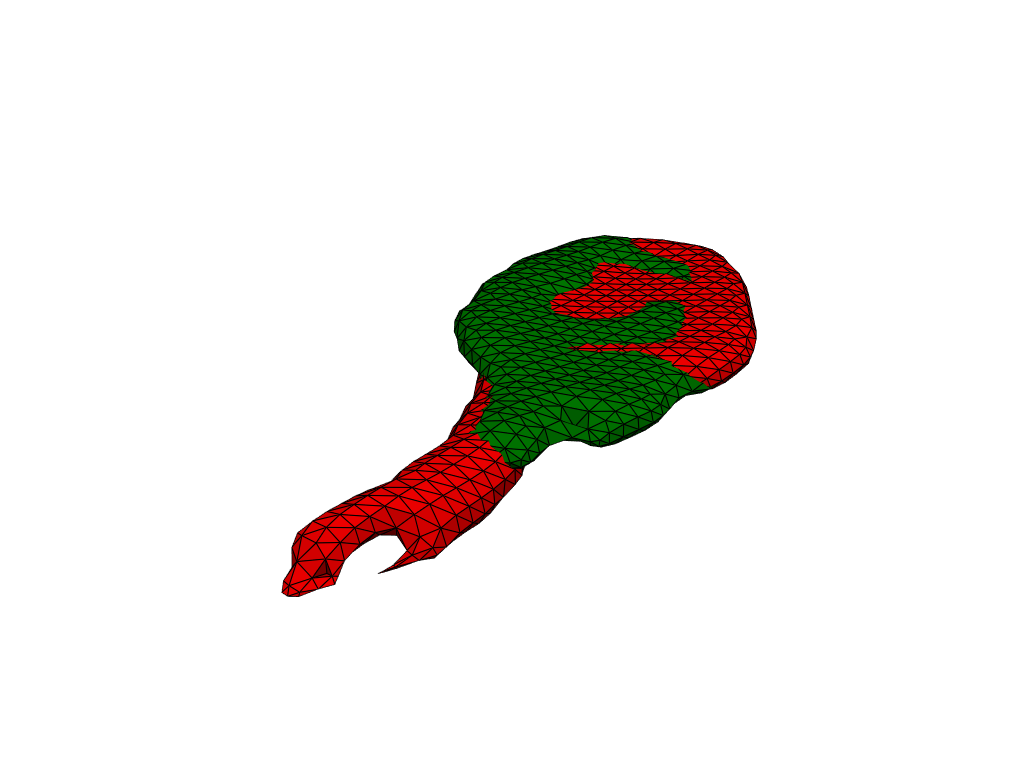

In [9]:
pl = pv.Plotter(border=False)

pl.add_mesh(meshes[0], show_edges=True, color="red")
pl.add_mesh(meshes[1], show_edges=True, color="green")

pl.show()

## Registration

Save meshes in `vtk` format (as required by `deformetrica`).

In [10]:
meshes_writer = Map(PvWriter(dirname=OUTPUTS_DIR, ext="vtk"))

mesh_filenames = [f"mesh_{which}" for which in ["source", "target"]]
mesh_filenames = meshes_writer(list(zip(mesh_filenames, meshes)))

Use LDDMM to register the meshes.

In [11]:
kernel_width = 10.0
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    tol=1e-16,
    attachment_kernel_width=2.0,
)

if not REGISTRATION_DIR.exists() or not ONLY_VIS:
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        output_dir=REGISTRATION_DIR,
        **registration_kwargs,
    )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/registration_posthipp/registration/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 10.0 and gpu_mode GpuMode.KERNEL. addr: 0x79478f84ae90
instantiating kernel torch with kernel_width 2.0 and gpu_mode GpuMode.KERNEL. addr: 0x79478ef7ec10
>> Set of 10 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

## Visualization

In [12]:
source, target = meshes

### Template and control points

In [13]:
cp = plddmm.io.load_cp(REGISTRATION_DIR)
momenta = plddmm.io.load_momenta(REGISTRATION_DIR)

template = plddmm.io.load_template(REGISTRATION_DIR, as_pv=True)

Confirm that source and template are the same mesh.

In [14]:
np.amax(np.abs(template.points - source.points))

0.0

Visualize template with control points.

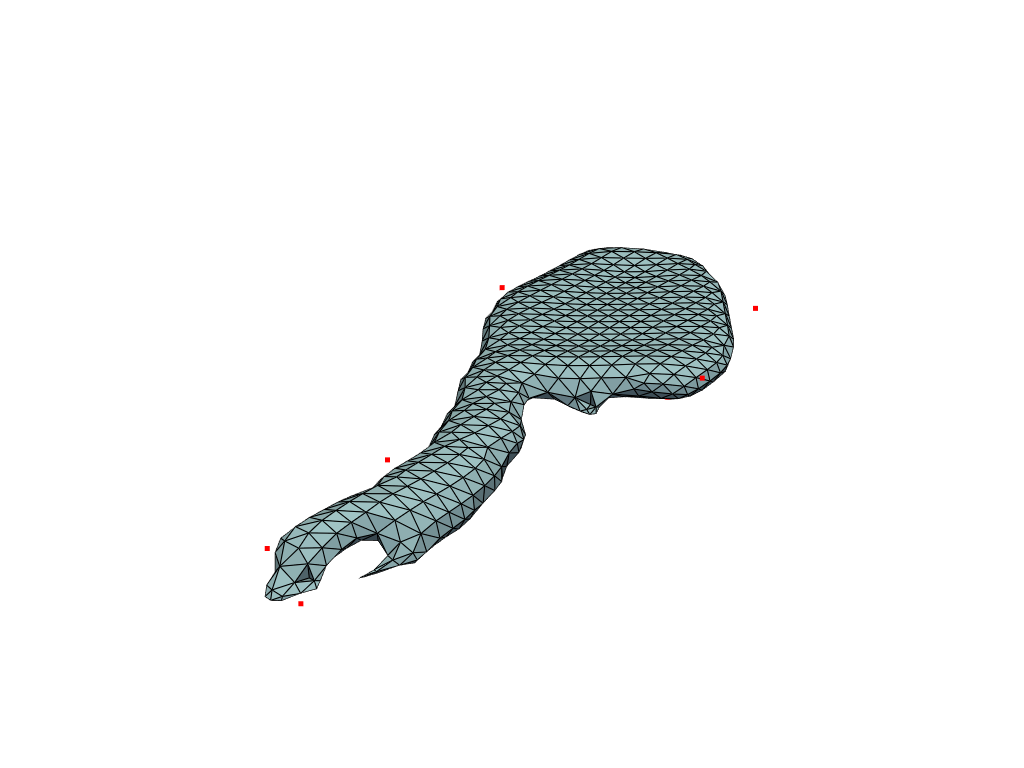

In [15]:
pl = pv.Plotter()

pl.add_mesh(template, show_edges=True)

# TODO: add velocity and allow for filtering
# control_points.set_active_scalars("Velocity")
pl.add_points(pv.PolyData(cp), color="red")

pl.show()

### Target and reconstructed meshes

In [16]:
reconstructed = plddmm.io.load_deterministic_atlas_reconstruction(
    REGISTRATION_DIR, as_pv=True
)

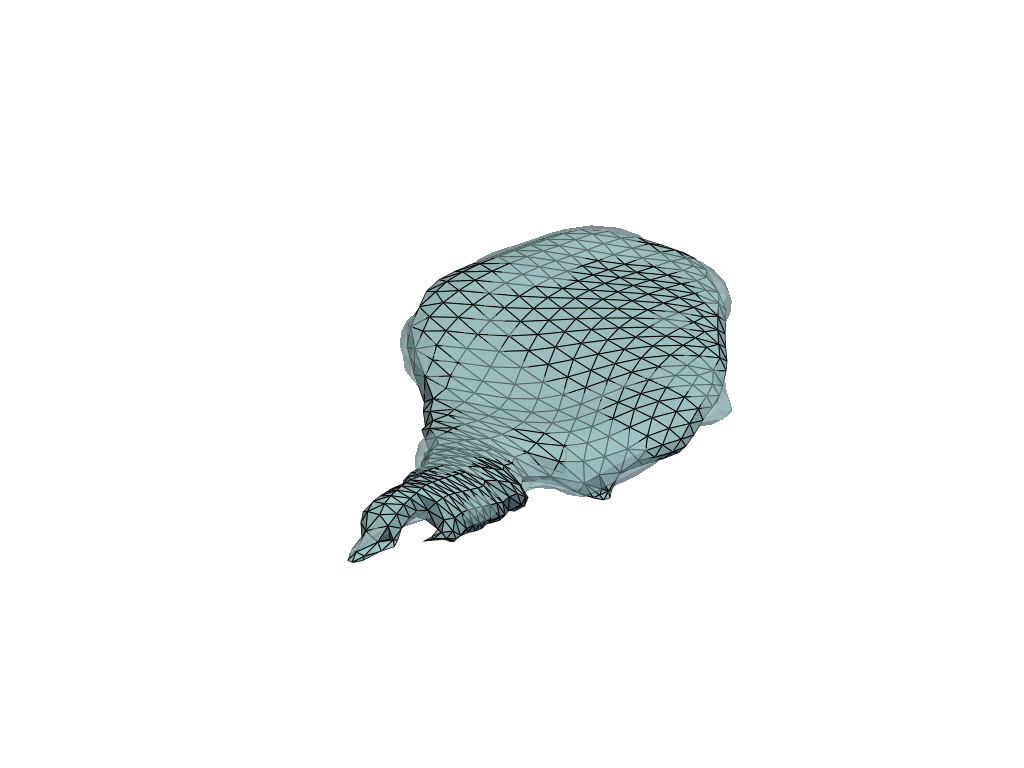

In [17]:
pl = pv.Plotter()

pl.add_mesh(reconstructed, show_edges=True)
pl.add_mesh(target, opacity=0.55)

pl.show()

### Flow

In [18]:
flow_meshes = plddmm.io.load_deterministic_atlas_flow(
    REGISTRATION_DIR,
    as_pv=True,
)

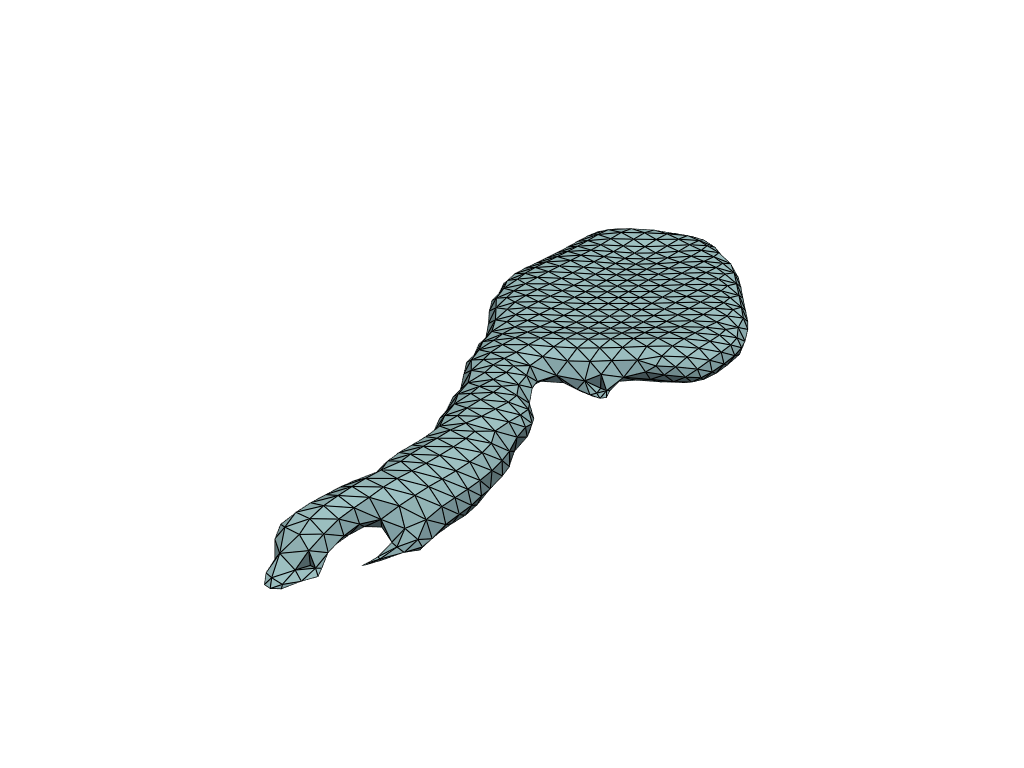

In [19]:
gif_dir = OUTPUTS_DIR / "_images"
gif_dir.mkdir(exist_ok=True)

gif_name = gif_dir / "flow.gif"


pl = RegisteredMeshesGifPlotter(
    gif_name=gif_name.as_posix(),
)

pl.add_meshes(flow_meshes)
pl.close()

pl.show()

### Reconstruct flow by shooting

In [20]:
SHOOT_DIR = OUTPUTS_DIR / "shoot"

In [21]:
plddmm.geometry.shoot(
    source=plddmm.io.load_template(REGISTRATION_DIR, as_path=True),
    control_points=plddmm.io.load_cp(REGISTRATION_DIR, as_path=True),
    momenta=plddmm.io.load_momenta(REGISTRATION_DIR, as_path=True),
    kernel_width=kernel_width,
    output_dir=SHOOT_DIR,
    write_adjoint_parameters=False,
)

[ compute_shooting function ]
Defaulting geodesic t0 to 0.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.


/home/luisfpereira/miniconda3/lib/python3.11/site-packages/in_out/dataset_functions.py:265: UserWarning: Watch out, I did not get a distance type for the object shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


In [22]:
flow_meshes_ = (LoadMeshFlow(as_path=False) + ppdict.DictToValuesList())(SHOOT_DIR)

diffs = [
    np.abs(np.amax(mesh.points - cmp_mesh.points))
    for mesh, cmp_mesh in zip(flow_meshes, flow_meshes_)
]

# TODO: identify origin of differences
np.amax(diffs)

0.46335089206695557

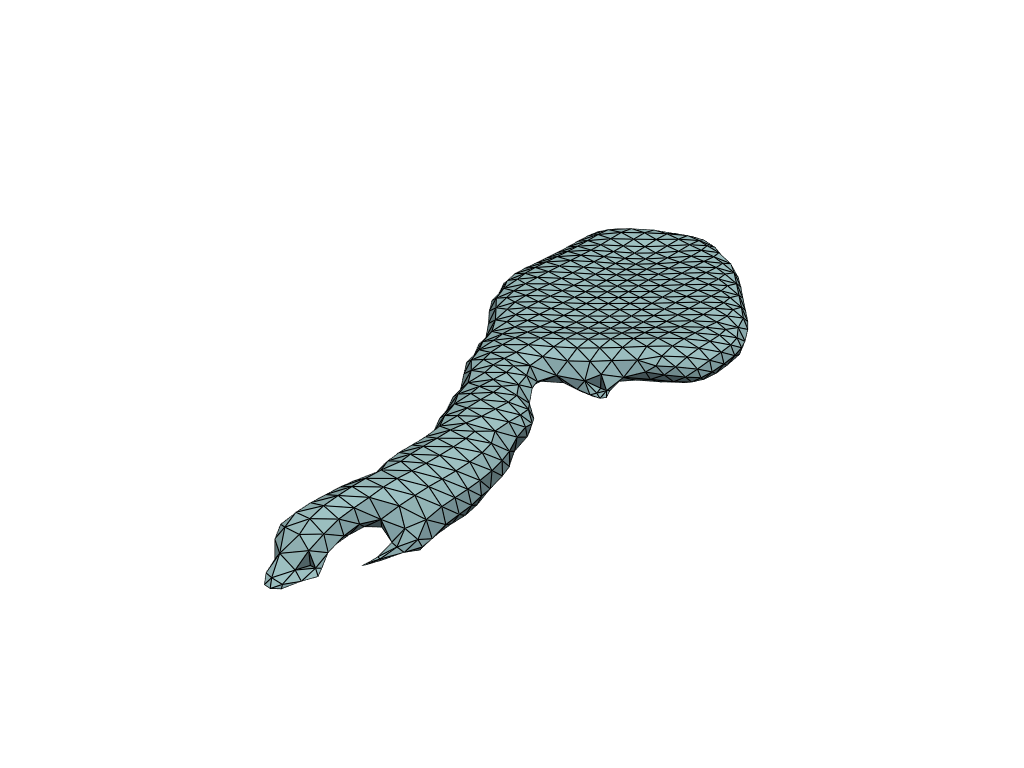

In [23]:
gif_dir = OUTPUTS_DIR / "_images"
gif_dir.mkdir(exist_ok=True)

gif_name = gif_dir / "flow.gif"


pl = RegisteredMeshesGifPlotter(
    gif_name=gif_name.as_posix(),
)

pl.add_meshes(flow_meshes_)
pl.close()

pl.show()

## Further reading

* [LDDMM: how to estimate a deterministic atlas?](./lddmm_deterministic_atlas.ipynb)

* [LDDMM: how to do regression?](./lddmm_regression.ipynb)